In [80]:
#Importing the necessary modulues beforehand is a good practice
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [81]:
#Classes of the dataset should be defined explicitly
labels_str={
0:"Hit",
1:"Kick",
2:"Punch",
3:"Push",
4:"ridehorse",
5:"shootgun",
6:"stand",
7:"wave"}

## Preparing the Data

In [82]:
DATA_DIR = "../input/fight-dataset/actions (2)/actions" #root directory comtaning the dataset.

TRAIN_DIR = DATA_DIR + '/train'                           # Sub-directory containing training images
TEST_DIR = DATA_DIR + '/test'                             # Sub-directory containing test images

In [83]:
#Initializing the values needed.
batch_size = 64 
stats = ([0.485, 0.456, 0.406] #mean value of each channel in imagenet dataset.
         , [0.229, 0.224, 0.225]) #standard deviation value of each channel in imagenet dataset.
image_size=224 #size of the image required. 

In [84]:
#ImageFolder is very useful for image datasets as it takes the labels from the folder names and sends the images accordingly to the model.
train_ds = ImageFolder(TRAIN_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)), #getting all the iamges of unique size as the images in the dataset may be of different sizes.
    T.ToTensor(), #converts the arrays to tensor.
    T.Normalize(*stats)])) #Normalizing the data which will be very useful for early convergence during training.
#val denotes validation set.Here we will use our test data as validation data.
val_ds = ImageFolder(TEST_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(*stats)])) #'*' will make the tuple values according to arguements.

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) #The last two parameters are used to optimize the loading of the data to the gpu.
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

68048


In [85]:
#The below function is used to renormalize the image for visualization of the dataset.
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] 
#The below 2 functions are used for visualizing the images in grid form.
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

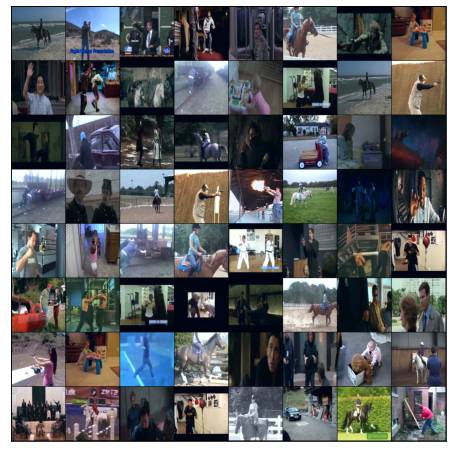

In [86]:
show_batch(train_dl)

## Model - Transfer Learning

In [87]:
#FBeta Score is an evaluation metric used for complex datasets which is used to determine the performance of the model.
def F_score(output, label, threshold=0.5, beta=1):
    prob = torch.argmax(torch.exp(output)/sum(torch.exp(output)),axis=-1).view(1,-1) #don't forget about axis and view.

    TP = (prob & label).sum(1).float() #True Positive -> Total number of True predictions that are actually True.
    TN = ((~prob) & (~label)).sum(1).float() #True Negative -> Total number of False predictions that are actually False.
    FP = (prob & (~label)).sum(1).float() #False Positive -> Total number of False prdictions that are actually True.
    FN = ((~prob) & label).sum(1).float() #False Negative -> Total number of True predictions that are actually False

    precision = torch.mean(TP / (TP + FP + 1e-12)) #Predictions that are actually True among the Total Predicted True values.
    recall = torch.mean(TP / (TP + FN + 1e-12)) #Predictions that are actually True among the Total actual True values.
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [88]:
#This class is used for training and validation purposes which i have explained in my previous posts. For clarification you can refer there which I will linking down.
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets= batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [89]:
#There are more stae-of-the-Art pre-trained models which are mostly trained on ImageNet dataset. Resnet is one of them.
resnet18 = models.resnet34(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Using a pretrained model
        self.network = models.resnet34(pretrained=True) #pretrained states that the model is taken with trained weights.
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 256)
        #Adding top layers for better performance.
        self.network1=nn.Linear(256,8)
        self.networkact=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self, xb):
        out=self.network(xb)
        out=self.networkact(out)
        out=self.network1(out)
        return self.softmax(out) #for matrices dimension is 1 as we say to model to do softmax to the last dimension(i.e vectors)
    #the below function will make only the top layers to be available for training i.e the layers we added.
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    #the below function will make the entire model trainable.
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [91]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [92]:
device = get_default_device()
device

device(type='cuda')

In [93]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [94]:
@torch.no_grad() #Not to perform any backprop calculation during this cell is running.
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
#the below function is used to get the learning_rate from the optimizer.
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#Fit function for one-cyclical-learningrate-scheduler.
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0.1, grad_clip=True, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() #To clear unwanted training data from memory
    history = []
    
    # Set up custom optimizer with weight decay where weight decay is a type of regularization technique which is used to reduce overfitting.
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay) 
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping which is used to prevent exploding gradients i.e gradient values which will go very high.
            #Here gradient values will be cutted off to a value when it goes beyond that value i.e if value>1,then value=1.
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if(result['val_score']>=0.825):# and result['val_loss']<1.51):
            break
    return history

In [95]:
#Fit function for Learning_rate_finder
def fit(epochs, start_lr,end_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    lrs=[]

    # Make lists to capture the logs
    lr_find_lr = []
    
    # LR function lambda

    lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (epochs * len( train_dl))) 

    optimizer = opt_func(model.parameters(), start_lr )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            #Updating gradients
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        #logging lr at each epoch end.
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lr_find_lr
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [96]:
model = to_device(ProteinResnet(), device) 

In [20]:
model.unfreeze() #unfreezing to get the optimal learning rate.

In [21]:
#Initializing the required values for learning_rate_finder.
epochs = 10
start_lr = 1e-7
end_lr = 0.1
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit(epochs, start_lr,end_lr, model, train_dl, val_dl, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0000, train_loss: 2.0637, val_loss: 2.0479, val_score: 0.5710



Epoch [1], last_lr: 0.0000, train_loss: 1.8552, val_loss: 1.7818, val_score: 0.6999



Epoch [2], last_lr: 0.0000, train_loss: 1.5363, val_loss: 1.5471, val_score: 0.7890



Epoch [3], last_lr: 0.0000, train_loss: 1.3196, val_loss: 1.5081, val_score: 0.7979



Epoch [4], last_lr: 0.0001, train_loss: 1.2924, val_loss: 1.5340, val_score: 0.7964



Epoch [5], last_lr: 0.0004, train_loss: 1.3383, val_loss: 1.7589, val_score: 0.6882



Epoch [6], last_lr: 0.0016, train_loss: 1.5312, val_loss: 1.9560, val_score: 0.7162



Epoch [7], last_lr: 0.0063, train_loss: 1.9335, val_loss: 2.1010, val_score: 0.7674



Epoch [8], last_lr: 0.0251, train_loss: 2.0445, val_loss: 2.1010, val_score: 0.7674



Epoch [9], last_lr: 0.1000, train_loss: 2.0444, val_loss: 2.1010, val_score: 0.7674
CPU times: user 13min 25s, sys: 4min 46s, total: 18min 12s
Wall time: 1h 8min 58s


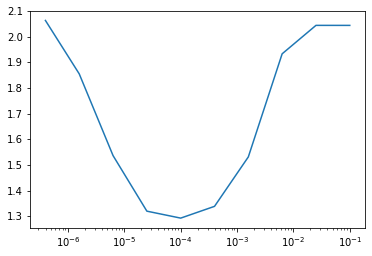

In [23]:
#Plotting Learning_rate vs Training_Loss
import matplotlib.pyplot as plt
plt.semilogx([x.get('lrs') for x in history][-1],[x.get('train_loss') for x in history][1:])

In [97]:
model = to_device(ProteinResnet(), device) #Re-initializing the model to start training.

In [98]:
#If you want load the weights and start testing the model,you can uncomment the below 2 lines and directly go to prediction section
model.load_state_dict(torch.load("./savedmodelfight1.pth"))
model.eval()

ProteinResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [99]:
model.freeze()

In [100]:
#Initializing the required values.
epochs = 8
max_lr = 8e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time 
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0000, train_loss: 1.2772, val_loss: 1.5233, val_score: 0.7856



Epoch [1], last_lr: 0.0001, train_loss: 1.2838, val_loss: 1.5505, val_score: 0.7868


Now, unfreeze and train some more.

In [33]:
model.unfreeze()

In [34]:
%%time 
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func )


Epoch [0], last_lr: 0.0000, train_loss: 1.2777, val_loss: 1.5224, val_score: 0.8196



Epoch [1], last_lr: 0.0001, train_loss: 1.2834, val_loss: 1.5322, val_score: 0.8258



Epoch [2], last_lr: 0.0001, train_loss: 1.2860, val_loss: 1.5712, val_score: 0.8172



Epoch [3], last_lr: 0.0001, train_loss: 1.2810, val_loss: 1.5030, val_score: 0.8209



Epoch [4], last_lr: 0.0000, train_loss: 1.2788, val_loss: 1.4648, val_score: 0.8225



Epoch [5], last_lr: 0.0000, train_loss: 1.2776, val_loss: 1.5155, val_score: 0.8134



Epoch [6], last_lr: 0.0000, train_loss: 1.2770, val_loss: 1.4938, val_score: 0.8233



Epoch [7], last_lr: 0.0000, train_loss: 1.2767, val_loss: 1.4861, val_score: 0.8214
CPU times: user 11min 29s, sys: 3min 49s, total: 15min 19s
Wall time: 54min 27s


In [35]:
#use the below line for saving the weights to a directory in pth format which you can use for next training i.e when you start again from the same spot you left training.
torch.save(model.state_dict(), "savedmodelfight1.pth")

In [73]:
#Now let's evaluate the model with final results.
print([evaluate(model, val_dl)])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [36]:
#Let's now plot the validation F-beta scores.
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

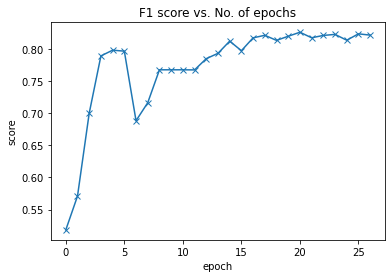

In [37]:
plot_scores(history)

In [38]:
#Here we plot train_loss and val_loss to check for overfitting.
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

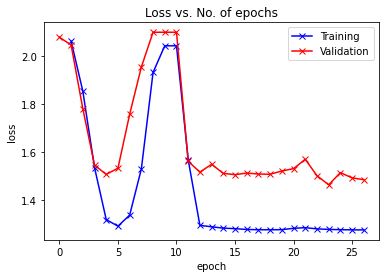

In [39]:
plot_losses(history)

In [65]:
#This graph shows how learning rate values went through the training.
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs[100:])
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

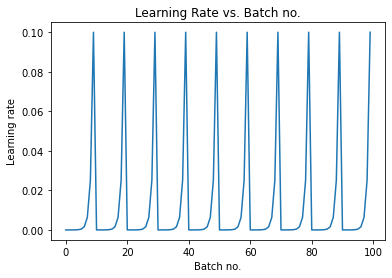

In [66]:
plot_lrs(history)

## Making predictions and submission

In [ ]:
def predict_single(image,label):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)  #to load the image to the gpu memory.
    preds = model(xb)
    prediction = preds[0]
    print("Actual Label: ",labels_str[label])
    print("Prediction: ", labels_str[torch.argmax(prediction).tolist()]) #The predicted class is extracted from the predicted values.
    show_images(image)

**Let us now predict using the model to see the performance.**

In [ ]:
predict_single(*val_ds[258])

In [ ]:
predict_single(*val_ds[1500])